## Manual vs. Sklearn KNN with simple data (2 columns)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('DATA/simple_data.csv')

# Separate labels from characteristics
X = df.iloc[:,0:2]  # characteristics
y = df["Label"]   # labels

df 

,X,Y,Label
0,2.373546,5.398106,0
1,3.183643,4.387974,0
2,2.164371,5.341120,0
3,4.595281,3.870637,0
4,3.329508,6.433024,0
...,...,...,...
95,4.249181,5.952016,1
96,7.087167,8.441158,1
97,5.017396,5.984153,1
98,3.713699,7.411975,1


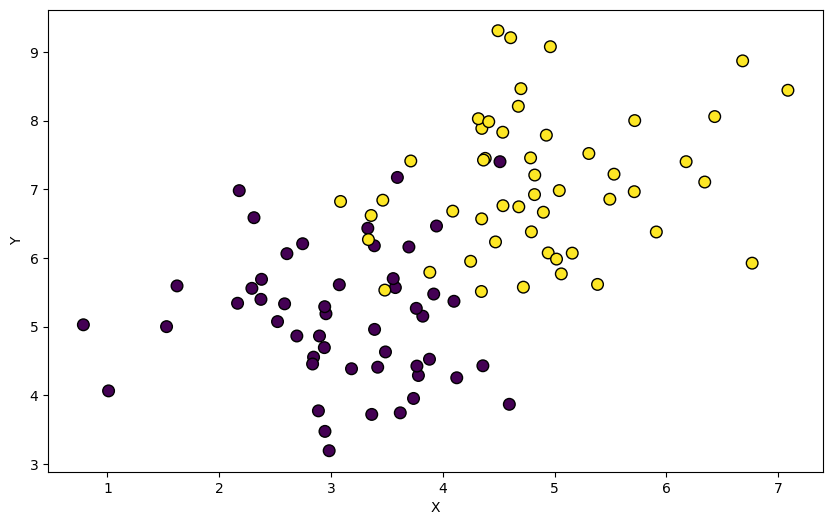

In [2]:
plt.figure(figsize=(10,6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k", s=70)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### KNN built manually

We need to compute the distance between each of the points in our data set. <BR>We’ll store this information in a distance matrix, which is a simple 2D array in which the distance between point i and point j is found at the array entry distance.matrix[i, j]. <BR>The following code produces this distance matrix using the Euclidean distance formula:

In [3]:
# Function 1
def distance_matrix(df):
    n = df.shape[0]
    distance = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            distance[i, j] = np.sqrt((df.iloc[i, df.columns.get_loc('X')] - df.iloc[j, df.columns.get_loc('X')]) ** 2 +
                                    (df.iloc[i, df.columns.get_loc('Y')] - df.iloc[j, df.columns.get_loc('Y')]) ** 2)
    
    return distance

And we also need a function that will return the k-nearest neighbors for a point, based on that matrix

In [4]:
# Function 2 (calls Function 1)
def my_k_nearest_neighbors(i, distance_matrix, k):
    # The following gives the list of points that are closest to row i in descending order.
    ordered_neighbors = np.argsort(distance_matrix[i,])
    
    return ordered_neighbors[1:(k + 1)]

Note that the first element (column) is always 0 (the nearest point is the point itself), so let's ignore it and return the points 1:(k+1) instead of 0:k.

Once you’ve done that, we’ll build a knn function that takes a data frame and a value for k and then produces predictions for each point in the data frame.

In [6]:
# we initially choose k=5 (a recommendation: k should not be greater than sqrt(n)

from scipy.spatial.distance import euclidean

# Function 3 (calls Functions 1 & 2)
def myknn(mydf, k=5): 
    distance = distance_matrix(mydf)
    predictions = np.empty(mydf.shape[0], dtype=int) # Creatse an array with the same number of elements as mydf has rows.
    
    for i in range(mydf.shape[0]):
        indices = my_k_nearest_neighbors(i, distance, k=k)
        if np.mean(mydf.iloc[indices, df.columns.get_loc('Label')]) > 0.5:
            predictions[i] = 1
        else:
            predictions[i] = 0
    
    return predictions

from scipy.spatial import distance
print(distance._METRICS_NAMES) # uncomment this to see a list of distance measures included

['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulczynski1', 'mahalanobis', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']


And now, everything together to make predictions and compute error

In [7]:
df['predictions'] = myknn(df, 5) # creates a column with the predictions
num_errors = sum(df['Label'] != df['predictions'])/len(df)
print("% Error: {0:.1%}".format(num_errors))
df

% Error: 7.0%


,X,Y,Label,predictions
0,2.373546,5.398106,0,0
1,3.183643,4.387974,0,0
2,2.164371,5.341120,0,0
3,4.595281,3.870637,0,0
4,3.329508,6.433024,0,1
...,...,...,...,...
95,4.249181,5.952016,1,1
96,7.087167,8.441158,1,1
97,5.017396,5.984153,1,1
98,3.713699,7.411975,1,1


### KNN from sklearn

Now, let’s try with an existing implementation of KNN with sklearn, and compare the results.

In [8]:
import random
from sklearn.neighbors import KNeighborsClassifier

n = df.shape[0]

# data splitting
indices = sorted(random.sample(range(n), int(n * 0.5))) # 50% each
training_points = df.iloc[indices, 0:2]
training_labels = df.iloc[indices, 2]
test_points = df.iloc[~df.index.isin(indices), 0:2]
test_labels = df.iloc[~df.index.isin(indices), 2]

In [9]:
print("Train set ", training_points.shape)
print("Test set", test_points.shape)

Train set  (50, 2)
Test set (50, 2)


In [10]:
# compute model
knn = KNeighborsClassifier(metric="euclidean", n_neighbors=5) # default is Minkowski with p=2, which is euclidean
knn.fit(training_points, training_labels) # not really a fit, but just stores in memory the data structure

# make predictions and compute % errors
predicted_labels = knn.predict(test_points)
num_errors = sum(predicted_labels != test_labels)/len(test_points)
print("% Error: {0:.1%}".format(num_errors))

% Error: 12.0%


We can also compare two solutions, first one without weighting and second one with the weighting  based on distance (inverse of it)

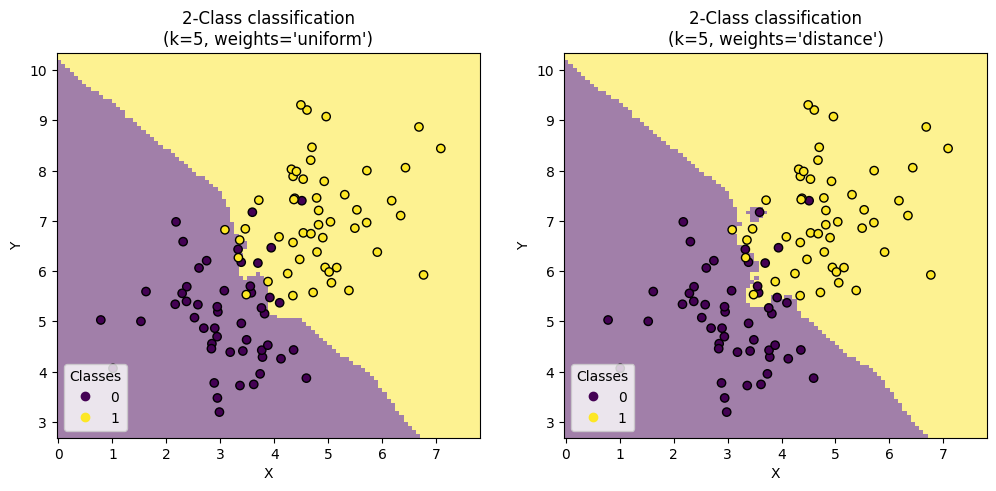

In [11]:
from sklearn.inspection import DecisionBoundaryDisplay

targetnames = np.unique(y, return_counts=False)

_, axs = plt.subplots(ncols=2, figsize=(12, 5)) #2 subplots, one in each column

for ax, weights in zip(axs, ("uniform", "distance")): # the two weighting schemes
    knn.set_params(weights=weights, n_neighbors=5).fit(training_points, training_labels)
    disp = DecisionBoundaryDisplay.from_estimator(
        knn,
        test_points,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="X",
        ylabel="Y",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        targetnames,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"2-Class classification\n(k={knn.n_neighbors}, weights={weights!r})"
    )

plt.show()

And a scatterplot with class predictions

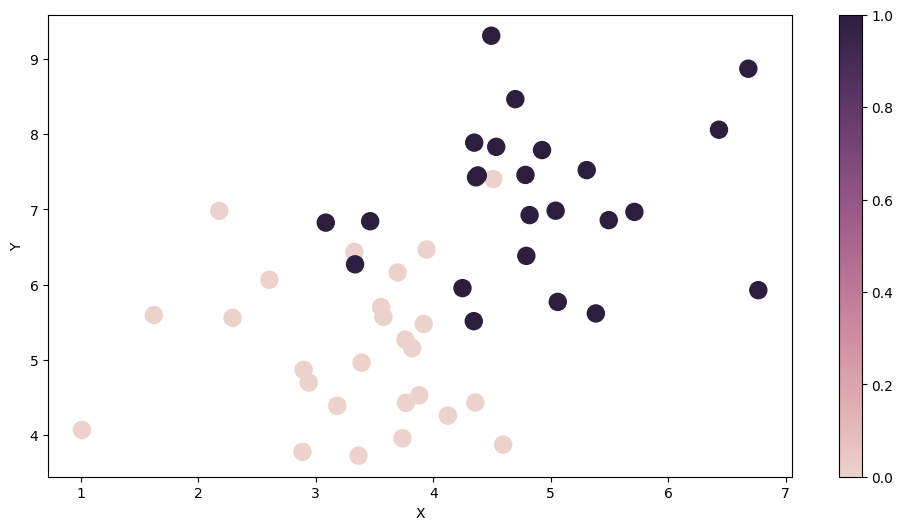

In [12]:
import seaborn as sns

cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(12, 6))
plt.xlabel("X")
plt.ylabel("Y")

points = ax.scatter(test_points.iloc[:, 0], test_points.iloc[:, 1], c=test_labels, s=150, cmap=cmap)
f.colorbar(points)

plt.show()

Finally, we create a meshgrid object to see probabilities and predictions together

In [13]:
#!pip install plotly 

import plotly.graph_objects as go

mesh_size = .02
margin = 0.25

# Create a mesh grid on which we will run our model
x_min, x_max = X.iloc[:, 0].min() - margin, X.iloc[:, 0].max() + margin
y_min, y_max = X.iloc[:, 1].min() - margin, X.iloc[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# run predictions on grid
Z = knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the figure
fig = go.Figure(data=[
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        colorscale='RdBu'
    )
])
fig.update_layout(width=1100, height=600) 
fig.show()

c:\Users\SLO\Documents\GitHub\IE-University\myenv312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
